In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
from PIL import Image
import torchvision.transforms as transforms

In [19]:
class AffectNetDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None, target_transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 1]
        img_path = os.path.join(self.root_dir, f"class00{self.data.iloc[idx, 0]}", img_name)
        image = Image.open(img_path).convert("RGB")
        
        label = self.data.iloc[idx, 0] - 1 # -1 because classes start at 1
        
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [20]:
train_csv = "/kaggle/input/affectnet-balanced/AffectNet_balanced_train.csv"
val_csv = "/kaggle/input/affectnet-balanced/AffectNet_balanced_val.csv"

train_dir = "/kaggle/input/affectnet/affectnet/train"
val_dir = "/kaggle/input/affectnet/affectnet/val_class"

In [21]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [22]:
train_dataset = AffectNetDataset(train_csv, train_dir, transform=transform)
val_dataset = AffectNetDataset(val_csv, val_dir, transform=transform)

In [23]:
batch_size = 92
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [8]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=d56063b5aab2f717d7414f1f21cc1d176f72cf5e0afbb9e54baaca88d0078e13
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [25]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_name('efficientnet-b2')
num_classes = 8  # Встановіть правильну кількість класів
model._fc = torch.nn.Linear(model._fc.in_features, num_classes)
model.to(device)
model.eval()

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False
    

In [10]:
!pip install timm==0.4.5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 8.8 MB/s eta 0:00:00
  Attempting uninstall: timm
    Found existing installation: timm 0.9.2
    Uninstalling timm-0.9.2:
      Successfully uninstalled timm-0.9.2


In [11]:
import timm
model.state_dict = torch.load("/kaggle/input/effnet-b2/enet_b2_8_best.pt")
model.to(device)
model.eval()

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False
    

In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [27]:
from tqdm import tqdm
num_epochs = 15

train_accuracies = []
val_accuracies = []

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Тренування
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_dataloader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        # Пряме поширення та обчислення втрат
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Обчислення градієнтів та зворотне поширення
        loss.backward()
        optimizer.step()

        # Обчислення точності
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        train_loss += loss.item()

    train_accuracy = 100 * correct / total
    train_accuracies.append(train_accuracy)
    
    avg_train_loss = train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    # Валідація
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_dataloader:
            images, labels = images.to(device), labels.to(device)

            # Пряме поширення та обчислення втрат
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Обчислення точності
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            val_loss += loss.item()

    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    avg_val_loss = val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)

    # Виведення метрик на епоху
    print(f"Epoch {epoch+1}/{num_epochs}:\n"
          f"Train Loss: {avg_train_loss:.4f} | Train Accuracy: {train_accuracy:.2f}%\n"
          f"Val Loss: {avg_val_loss:.4f} | Val Accuracy: {val_accuracy:.2f}%\n")


100%|██████████| 140/140 [02:55<00:00,  1.25s/it]


Epoch 1/15:
Train Loss: 2.1038 | Train Accuracy: 14.78%
Val Loss: 2.0745 | Val Accuracy: 14.15%



100%|██████████| 140/140 [02:54<00:00,  1.25s/it]


Epoch 2/15:
Train Loss: 2.0667 | Train Accuracy: 15.71%
Val Loss: 2.0769 | Val Accuracy: 13.11%



100%|██████████| 140/140 [02:54<00:00,  1.25s/it]


Epoch 3/15:
Train Loss: 2.0472 | Train Accuracy: 17.25%
Val Loss: 2.0433 | Val Accuracy: 16.43%



100%|██████████| 140/140 [02:53<00:00,  1.24s/it]


Epoch 4/15:
Train Loss: 1.9205 | Train Accuracy: 23.26%
Val Loss: 4.3209 | Val Accuracy: 19.63%



100%|██████████| 140/140 [02:54<00:00,  1.24s/it]


Epoch 5/15:
Train Loss: 1.7704 | Train Accuracy: 29.28%
Val Loss: 2.1851 | Val Accuracy: 27.08%



100%|██████████| 140/140 [02:54<00:00,  1.25s/it]


Epoch 6/15:
Train Loss: 1.6724 | Train Accuracy: 32.70%
Val Loss: 1.8617 | Val Accuracy: 27.45%



100%|██████████| 140/140 [02:56<00:00,  1.26s/it]


Epoch 7/15:
Train Loss: 1.5861 | Train Accuracy: 36.30%
Val Loss: 1.7360 | Val Accuracy: 33.60%



100%|██████████| 140/140 [02:55<00:00,  1.26s/it]


Epoch 8/15:
Train Loss: 1.4898 | Train Accuracy: 41.14%
Val Loss: 1.7541 | Val Accuracy: 34.58%



100%|██████████| 140/140 [02:59<00:00,  1.28s/it]


Epoch 9/15:
Train Loss: 1.3966 | Train Accuracy: 44.85%
Val Loss: 1.7605 | Val Accuracy: 38.52%



100%|██████████| 140/140 [02:55<00:00,  1.25s/it]


Epoch 10/15:
Train Loss: 1.2876 | Train Accuracy: 50.19%
Val Loss: 1.9989 | Val Accuracy: 34.89%



100%|██████████| 140/140 [03:02<00:00,  1.30s/it]


Epoch 11/15:
Train Loss: 1.1777 | Train Accuracy: 54.41%
Val Loss: 1.8408 | Val Accuracy: 37.54%



100%|██████████| 140/140 [02:56<00:00,  1.26s/it]


Epoch 12/15:
Train Loss: 1.0601 | Train Accuracy: 59.00%
Val Loss: 2.1181 | Val Accuracy: 36.74%



100%|██████████| 140/140 [02:58<00:00,  1.28s/it]


Epoch 13/15:
Train Loss: 0.9352 | Train Accuracy: 64.44%
Val Loss: 2.2510 | Val Accuracy: 36.80%



100%|██████████| 140/140 [02:55<00:00,  1.25s/it]


Epoch 14/15:
Train Loss: 0.8384 | Train Accuracy: 68.07%
Val Loss: 2.5366 | Val Accuracy: 37.60%



100%|██████████| 140/140 [02:54<00:00,  1.25s/it]


Epoch 15/15:
Train Loss: 0.7230 | Train Accuracy: 73.02%
Val Loss: 2.2964 | Val Accuracy: 40.00%



In [ ]:
### balanced dataset

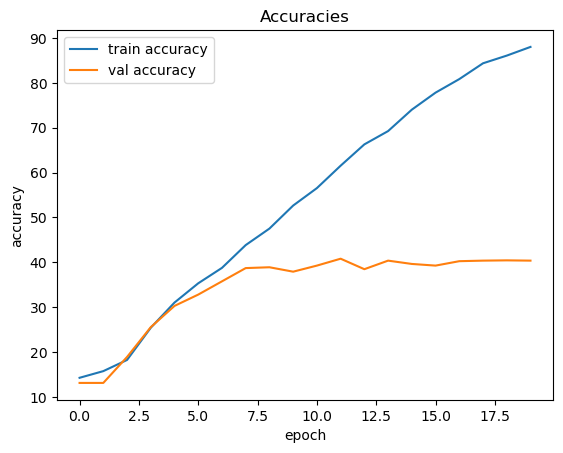

In [16]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.arange(len(train_accuracies)), train_accuracies)
plt.plot(np.arange(len(val_accuracies)), val_accuracies)
plt.title("Accuracies")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(["train accuracy", "val accuracy"])
plt.show()

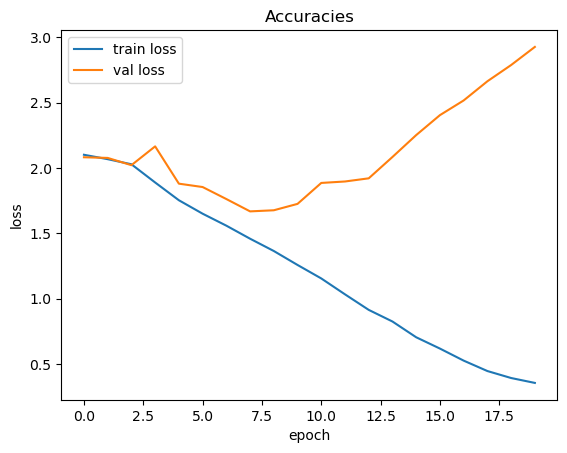

In [17]:
plt.plot(np.arange(len(train_losses)), train_losses)
plt.plot(np.arange(len(val_losses)), val_losses)
plt.title("Accuracies")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["train loss", "val loss"])
plt.show()

### also balanced dataset but different efficientnet

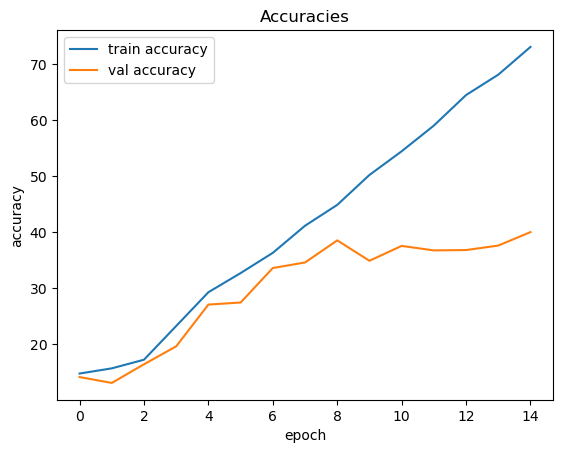

In [28]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.arange(len(train_accuracies)), train_accuracies)
plt.plot(np.arange(len(val_accuracies)), val_accuracies)
plt.title("Accuracies")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(["train accuracy", "val accuracy"])
plt.show()

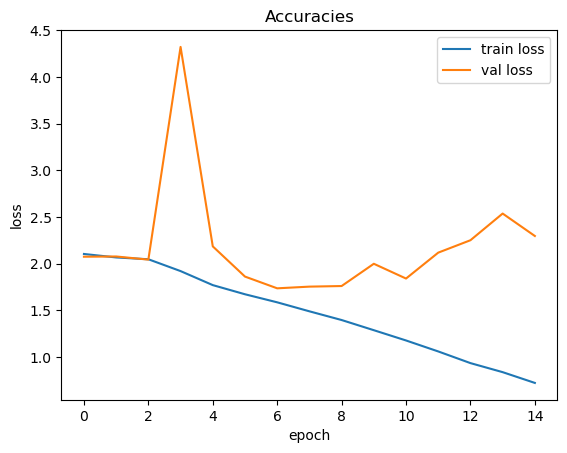

In [29]:
plt.plot(np.arange(len(train_losses)), train_losses)
plt.plot(np.arange(len(val_losses)), val_losses)
plt.title("Accuracies")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["train loss", "val loss"])
plt.show()